In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
wf = open('npypaths_MemNets.csv', 'w')
wf.write('experiment,model,npypath\n')
for root, dirs, files in os.walk('../model_ours/save+tw'):
    for file in files:
        if file == 'GMAN_groundtruth.npy':
            modelname = 'GroundTruth'
            experiment = root.split('_')[1].split('/')[-1][8:]
            # print(experiment, modelname, os.path.join(root, file))
            wf.write(','.join([experiment, modelname, os.path.join(root, file)]) + '\n')
        elif '_prediction.npy' in file:
            modelname = root.split('_')[2]
            #if modelname=='TransformerT': modelname='Transformer'
            if modelname=='GraphWaveNet': modelname='GW-Net'    
            experiment = root.split('_')[1].split('/')[-1][8:]
            # print(experiment, modelname, os.path.join(root, file))
            wf.write(','.join([experiment, modelname, os.path.join(root, file)]) + '\n')
        else:
            pass
wf.close()

In [3]:
df_npypath = pd.read_csv('npypaths_MemNets.csv')
df_npypath

,experiment,model,npypath
0,covid-inflow,AGCRN,../model_ours/save+tw\covid-inflow_AGCRN_20211...
1,covid-inflow,GroundTruth,../model_ours/save+tw\covid-inflow_GMAN_202111...
2,covid-inflow,GMAN,../model_ours/save+tw\covid-inflow_GMAN_202111...
3,covid-inflow,GW-Net,../model_ours/save+tw\covid-inflow_GraphWaveNe...
4,covid-inflow,MemeSTN,../model_ours/save+tw\covid-inflow_MemeSTN_202...
5,covid-outflow,AGCRN,../model_ours/save+tw\covid-outflow_AGCRN_2021...
6,covid-outflow,GroundTruth,../model_ours/save+tw\covid-outflow_GMAN_20211...
7,covid-outflow,GMAN,../model_ours/save+tw\covid-outflow_GMAN_20211...
8,covid-outflow,GW-Net,../model_ours/save+tw\covid-outflow_GraphWaveN...
9,covid-outflow,MemeSTN,../model_ours/save+tw\covid-outflow_MemeSTN_20...


In [4]:
from Utils import *
from configparser import ConfigParser

def get_npys(exp, models, npypath='npypaths_MemNets.csv'):
    df_npypath = pd.read_csv(npypath)
    npy_list = []
    for model in models:
        path = df_npypath[(df_npypath.experiment==exp)&(df_npypath.model==model)]['npypath'].values[0]
        npy = np.load(path)
        print('npy.shape, npy.min(), npy.max()', npy.shape, npy.min(), npy.max())
        npy_list.append(npy)
    return npy_list

def get_times(exp):
    config = ConfigParser()
    config.read('params.txt', encoding='UTF-8')
    freq = config[exp]['freq']
    target_start_date = config[exp]['target_start_date']
    target_end_date = config[exp]['target_end_date']
    target_all_times = [date.strftime('%Y-%m-%d %H:%M:%S') for date in pd.date_range(start=target_start_date, end=target_end_date, freq=freq)]
    target_all_times = np.array(target_all_times)
    _, test_times = getXSYS(target_all_times, 'test', 12, 12, 0.8)
    print('test_times.shape', test_times.shape)
    return test_times

In [5]:
import matplotlib.dates as mdates

def prepare_data(exp, models, prefectures, time_step_id):  
    prefectureids = get_pref_id('../data/Japan_prefectures.csv', prefectures)
    npy_list = get_npys(exp, models)
    test_times = get_times(exp)
    for i in range(len(npy_list)):
        npy_list[i] = npy_list[i][:, time_step_id, prefectureids]
        npy_list[i] = npy_list[i][:, np.newaxis, :]
#         if i==2:    # for GMAN horizon=12
#             npy_list[i] = np.concatenate([npy_list[i][3:]]+[npy_list[i][0][np.newaxis]]*6, axis=0)
#         print(npy_list[i].shape)
    npy_list = np.concatenate(npy_list, axis=1)
    test_times = test_times[:, time_step_id]
    return npy_list, test_times

def plot_typhoon(exp, prefectures, fdata, test_times, start_date, end_date):
    words = exp.split('-')
    words[0] = words[0].capitalize()
    words[1] = words[1].capitalize()
    exp_tmp = ' '.join(words)
    
    start_index, end_index = test_times.tolist().index(start_date), test_times.tolist().index(end_date)
    xdata = pd.to_datetime(test_times[start_index:end_index+1])
    fdata = fdata[start_index:end_index+1]

    fig = plt.figure(figsize=(12, 4),  constrained_layout=True, dpi=100)
    axes = fig.subplots(len(prefectures), 1, sharex=True, gridspec_kw={'hspace': 0.01})

    for area_idx in range(len(prefectures)):
        ax = axes[area_idx]
        ax.plot(xdata, fdata[:, :, area_idx], lw=1.0)
        ax.legend(labels=models, loc='upper right')
        ax.set_ylabel(prefectures[area_idx], fontweight='bold')
        ax.grid(which='major', zorder=1)
        ax.vlines(mdates.datestr2num('2019-10-12 19:00:00'), 0, fdata[:, :, area_idx].max(), colors='r', lw=1, linestyles='--', zorder=4)

    #fig.supylabel('GroundTruth v.s. Prediction on {}'.format(exp_tmp))

    # Add landfall labels
    fig.text(0.38, 0.95, 'Typhoon Hagibis Landfall')
    axes[-1].xaxis.set_major_locator(mdates.HourLocator(byhour=[0]))
    axes[-1].xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter(''))
    axes[-1].xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
    plt.setp(axes[-1].xaxis.get_minorticklabels(), rotation=0)
    axes[-1].set_xlim([xdata[0], xdata[-1]])

    plt.savefig('TruthPred_{}_{}.png'.format(words[0], words[1]))

In [6]:
from copy import copy

def plot_mem(att_tensor):
    print(att_tensor.shape)

    cmap = copy(plt.cm.plasma)
    cmap.set_bad(cmap(0))

    fig, ax = plt.subplots()
    plt.imshow(att_tensor.transpose(), cmap=cmap, aspect='auto')

#     ax.set_ylabel('Memory', fontsize=11)
#     ax.set_xticks([x for x in range(0, 24*190, 24*7)])
#     ax.set_xticklabels(['2019-Nov-15', 'Nov-22', 'Nov-29', 'Dec-6', 'Dec-13', 'Dec-20', 'Dec-27',
#                         '2020-Jan-3', 'Jan-10', 'Jan-17', 'Jan-24', 'Jan-31', 'Feb-7', 'Feb-14',
#                         'Feb-21', 'Feb-28', 'Mar-6', 'Mar-13', 'Mar-20', 'Mar-27', 'Apr-4', 'Apr-11',
#                         'Apr-18', 'Apr-26', 'May-3', 'May-10', 'May-17', 'May-24'], fontsize=11, rotation=20)

    fig.set_size_inches(50, 3)
    plt.subplots_adjust(bottom=0.3, top=0.7)
    plt.show()

    return

(584, 10)


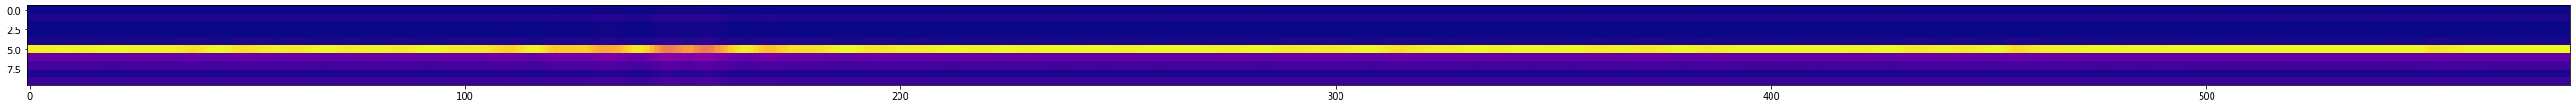

In [7]:
att_test = np.load(f'../model_ours/con_mem/covid-outflow_yes_202111101215/MemoryAGCRN_att_score.npy')
plot_mem(att_test)


In [8]:
exp = 'typhoon-inflow'
models = ['GroundTruth', 'GW-Net', 'GMAN', 'MemeSTN']
prefectures = ['Tokyo', 'Chiba', 'Osasaka']
time_step_id = 0 # future 1, 2, ..., 6 hours
fdata, times = prepare_data(exp, models, prefectures, time_step_id)
print(fdata.shape, times.shape, times[0], times[-1])
plot_typhoon(exp, prefectures, fdata, times, '2019-10-07 00:00:00', '2019-10-21 00:00:00') # 14 days

C:\Users\znwang\PycharmProjects\TwitterMobility\TwitterMobility1\visual\Utils.py:67: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return (jp_pref.loc[target_pref]['prefecture_code'] - 1).values.tolist()


npy.shape, npy.min(), npy.max() (584, 6, 47) 104.00000000000014 148262.0
npy.shape, npy.min(), npy.max() (584, 6, 47) -153.83937 158540.23
npy.shape, npy.min(), npy.max() (584, 6, 47) 65.983116 164695.56
npy.shape, npy.min(), npy.max() (584, 6, 47) 157.51634 159702.88
test_times.shape (581, 12)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

npy.shape, npy.min(), npy.max() (584, 6, 47) 102.99999999999997 160730.0
npy.shape, npy.min(), npy.max() (584, 6, 47) -1357.785 171369.33
npy.shape, npy.min(), npy.max() (584, 6, 47) -1477.9227 165739.58
npy.shape, npy.min(), npy.max() (584, 6, 47) 149.98009 171499.58
test_times.shape (581, 12)
(584, 4, 3) (581,) 2019-10-06 08:00:00 2019-10-30 12:00:00


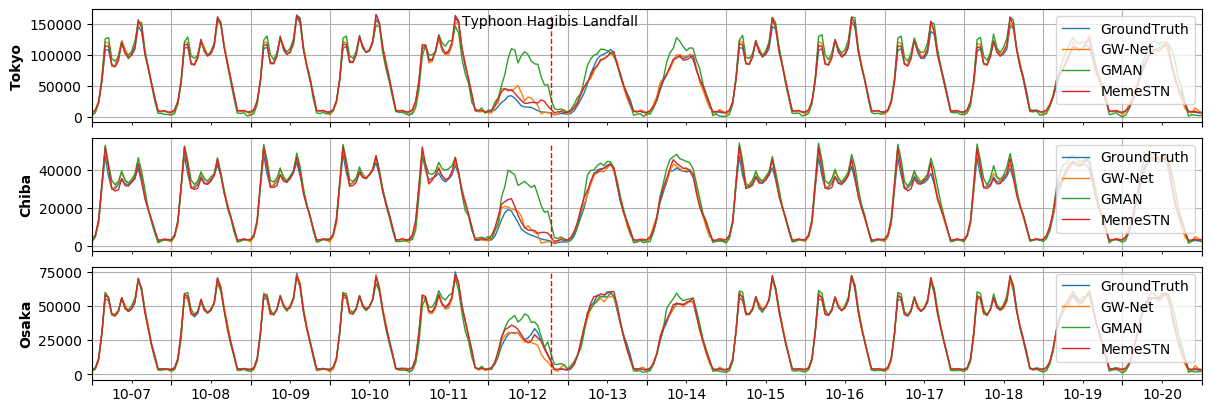

In [62]:
exp = 'typhoon-outflow'
models = ['GroundTruth', 'GW-Net', 'GMAN', 'MemeSTN']
prefectures = ['Tokyo', 'Chiba', 'Osaka']
time_step_id = 0 # future 1, 2, ..., 6 hours
fdata, times = prepare_data(exp, models, prefectures, time_step_id)
print(fdata.shape, times.shape, times[0], times[-1])
plot_typhoon(exp, prefectures, fdata, times, '2019-10-07 00:00:00', '2019-10-21 00:00:00') # 14 days

In [9]:
def plot_covid(exp, prefectures, fdata, test_times, start_date, end_date):
    words = exp.split('-')
    words[0] = words[0].capitalize()
    words[1] = words[1].capitalize()
    exp_tmp = ' '.join(words)
    
    start_index, end_index = test_times.tolist().index(start_date), test_times.tolist().index(end_date)
    xdata = pd.to_datetime(test_times[start_index:end_index+1])
    fdata = fdata[start_index:end_index+1]

    fig = plt.figure(figsize=(12, 4),  constrained_layout=True, dpi=100)
    axes = fig.subplots(len(prefectures), 1, sharex=True, gridspec_kw={'hspace': 0.01})

    for area_idx in range(len(prefectures)):
        ax = axes[area_idx]
        ax.plot(xdata, fdata[:, :, area_idx], lw=1.0)
        ax.legend(labels=models, loc='upper right')
        ax.set_ylabel(prefectures[area_idx], fontweight='bold')
        ax.grid(which='major', zorder=1)
    
    # fig.title('GroundTruth v.s. Prediction on {}'.format(exp_tmp))
    # fig.supylabel('GroundTruth v.s. Prediction on {}'.format(exp_tmp))

    # Add landfall labels
    axes[-1].xaxis.set_major_locator(mdates.HourLocator(byhour=[0]))
    axes[-1].xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter(''))
    axes[-1].xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
    plt.setp(axes[-1].xaxis.get_minorticklabels(), rotation=0)
    axes[-1].set_xlim([xdata[0], xdata[-1]])

    plt.savefig('TruthPred_{}_{}.png'.format(words[0], words[1]))

npy.shape, npy.min(), npy.max() (2035, 6, 47) 62.00000000000019 79430.0
npy.shape, npy.min(), npy.max() (2035, 6, 47) 35.11739 98169.77
npy.shape, npy.min(), npy.max() (2035, 6, 47) -14.570597 92542.016
npy.shape, npy.min(), npy.max() (2035, 6, 47) 89.19657 89277.47
test_times.shape (2033, 12)
(2035, 4, 3) (2033,) 2020-12-05 05:00:00 2021-02-27 21:00:00


C:\Users\znwang\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


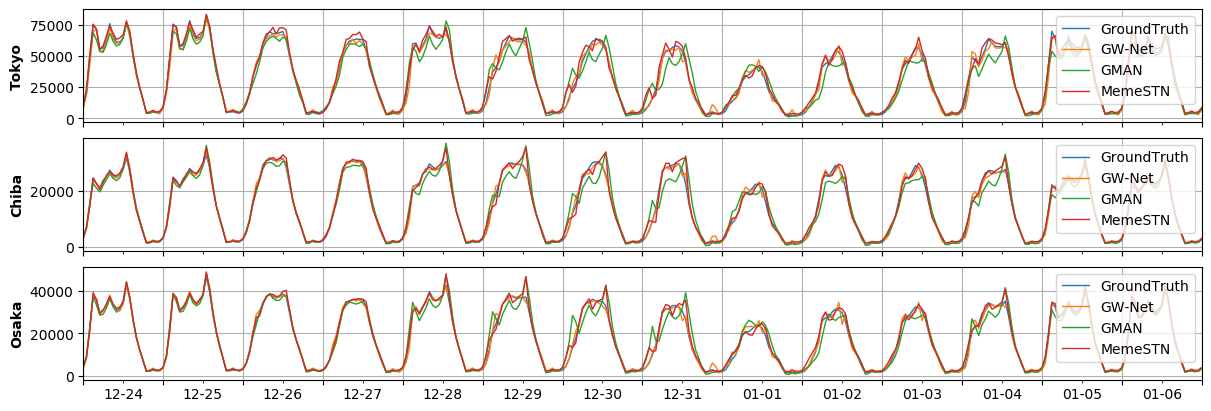

In [10]:
exp = 'covid-inflow'
models = ['GroundTruth', 'GW-Net', 'GMAN', 'MemeSTN']
prefectures = ['Tokyo', 'Chiba', 'Osaka']
time_step_id = 0 # future 1, 2, ..., 6 hours
fdata, times = prepare_data(exp, models, prefectures, time_step_id)
print(fdata.shape, times.shape, times[0], times[-1])
plot_covid(exp, prefectures, fdata, times, '2020-12-24 00:00:00', '2021-01-07 00:00:00')    # compound!?
#plot_covid(exp, prefectures, fdata, times, '2021-01-08 00:00:00', '2021-01-15 12:00:00') 

npy.shape, npy.min(), npy.max() (2035, 6, 47) 64.00000000000003 89251.0
npy.shape, npy.min(), npy.max() (2035, 6, 47) 7.529524 99196.01
npy.shape, npy.min(), npy.max() (2035, 6, 47) -6.5674663 97859.13
npy.shape, npy.min(), npy.max() (2035, 6, 47) 88.89284 97255.99
test_times.shape (2033, 12)
(2035, 4, 3) (2033,) 2020-12-05 05:00:00 2021-02-27 21:00:00


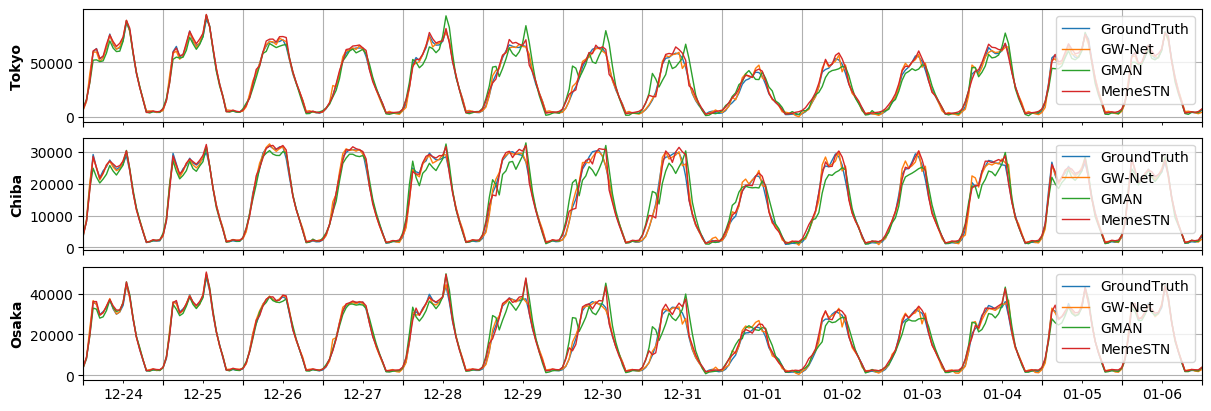

In [11]:
exp = 'covid-outflow'
models = ['GroundTruth', 'GW-Net', 'GMAN', 'MemeSTN']
prefectures = ['Tokyo', 'Chiba', 'Osaka']
time_step_id = 0 # future 1, 2, ..., 6 hours
fdata, times = prepare_data(exp, models, prefectures, time_step_id)
print(fdata.shape, times.shape, times[0], times[-1])
plot_covid(exp, prefectures, fdata, times, '2020-12-24 00:00:00', '2021-01-07 00:00:00')    # compound!?
# plot_covid(exp, prefectures, fdata, times, '2021-01-04 00:00:00', '2021-01-11 12:00:00') # 14 days